# Практическое задание

Володин Сергей Евгеньевич, 374

### Задача Bike Sharing

Задача на kaggle: https://www.kaggle.com/c/bike-sharing-demand

По историческим данным о прокате велосипедов и погодных условиях необходимо спрогнозировтаь спрос на прокат велосипедов.

В исходной псотановке задачи доступно 9 признаков: https://www.kaggle.com/c/prudential-life-insurance-assessment/data

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные. 

### Анализ и визуализация данных

In [1]:
from sklearn import cross_validation, ensemble, grid_search, linear_model, metrics, pipeline, preprocessing

import numpy as np
import pandas as pd

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Делаем datetime обычным признаком, а не индексом
df = pd.DataFrame.from_csv("bike_sharing_train.csv", index_col = False)

# Конвертируем дату в час-день-месяц-год + день недели
df.datetime = df.datetime.apply(pd.to_datetime)
df['hour'] = df.datetime.apply(lambda x: x.hour)
df['day'] = df.datetime.apply(lambda x: x.day)
df['month'] = df.datetime.apply(lambda x: x.month)
df['year'] = df.datetime.apply(lambda x: x.year)
df['dayofweek'] = df.datetime.apply(lambda x: x.dayofweek)
df.drop('datetime', axis = 1, inplace = True)

# перемещаем count в начало
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index('count')))
df = df.reindex(columns=cols)

In [4]:
df.sample(6)

,count,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month,year,dayofweek
3566,173,3,0,1,1,32.80,37.120,52,19.0012,12,18,8,2011,3
524,39,1,0,0,2,9.84,12.120,70,11.0014,0,5,2,2011,5
1825,64,2,0,1,2,22.96,26.515,83,12.9980,23,2,5,2011,0
9538,516,4,0,1,2,22.14,25.760,68,7.0015,19,1,10,2012,0
8959,431,3,0,1,1,31.16,34.090,48,12.9980,16,15,8,2012,2
6500,11,1,0,1,1,18.86,22.725,63,26.0027,2,8,3,2012,3


3 . Проанализируйте описание данных:

***datetime*** - hourly date + timestamp  

***season*** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

***holiday*** - whether the day is considered a holiday

***workingday*** - whether the day is neither a weekend nor holiday

***weather*** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    
***temp*** - temperature in Celsius

***atemp*** - "feels like" temperature in Celsius

***humidity*** - relative humidity

***windspeed*** - wind speed

***count*** - number of total rentals

"feels like", holiday, hour

windspeed -- влияет только при больших значениях

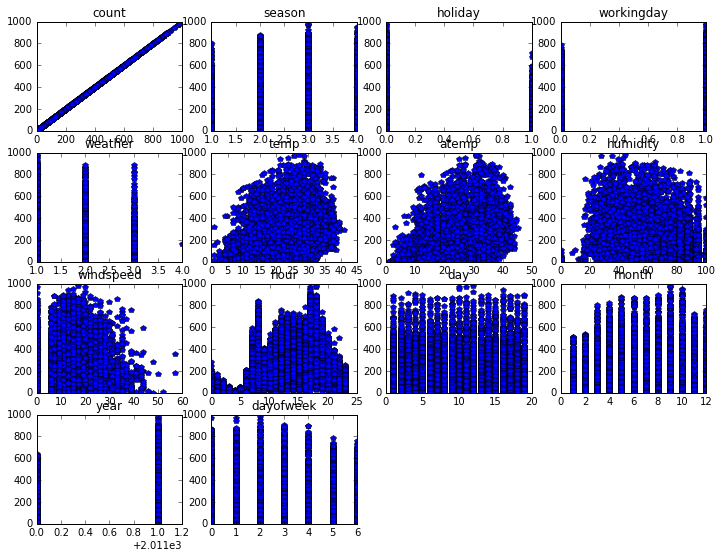

In [5]:
k = 1
plt.figure(figsize=(12,9))
for a in df:
    plt.subplot(4, 4, k)
    plt.plot(df[a], df['count'], 'p')
    plt.title(a)
    #plt.ylabel('count')
    k += 1

В 2012 спрос больше, чем в 2011. В праздники спрос меньше, в рабочие дни больше. Есть пики покупок утром и вечером.

In [6]:
df.corrwith(df['count'])

count         1.000000
season        0.163439
holiday      -0.005393
workingday    0.011594
weather      -0.128655
temp          0.394454
atemp         0.389784
humidity     -0.317371
windspeed     0.101369
hour          0.400601
day           0.019826
month         0.166862
year          0.260403
dayofweek    -0.002283
dtype: float64

влажность и час

In [7]:
df.corr()

,count,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month,year,dayofweek
count,1.000000,0.163439,-0.005393,0.011594,-0.128655,0.394454,0.389784,-0.317371,0.101369,0.400601,0.019826,0.166862,0.260403,-0.002283
season,0.163439,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,-0.006546,0.001729,0.971524,-0.004797,-0.010553
holiday,-0.005393,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,-0.000354,-0.015877,0.001731,0.012021,-0.191832
workingday,0.011594,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,0.002780,0.009829,-0.003394,-0.002482,-0.704267
weather,-0.128655,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.022740,-0.007890,0.012144,-0.012548,-0.047692
temp,0.394454,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.145430,0.015551,0.257589,0.061226,-0.038466
atemp,0.389784,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.140343,0.011866,0.264173,0.058540,-0.040235
humidity,-0.317371,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.278011,-0.011335,0.204537,-0.078606,-0.026507
windspeed,0.101369,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.146631,0.036157,-0.150192,-0.015221,-0.024804
hour,0.400601,-0.006546,-0.000354,0.002780,-0.022740,0.145430,0.140343,-0.278011,0.146631,1.000000,0.001132,-0.006818,-0.004234,-0.002925


In [8]:
ns = df.iloc[:,1:].columns.values
wh = np.where((df.drop('count', axis=1).corr() > 0.4) & ~np.diag([True] * 13))
zip(ns[wh[0]],ns[wh[1]])

[('season', 'month'),
 ('weather', 'humidity'),
 ('temp', 'atemp'),
 ('atemp', 'temp'),
 ('humidity', 'weather'),
 ('month', 'season')]

temp, atemp; season month; weather humidity

In [9]:
print df.mean()
print df.std()

count          191.574132
season           2.506614
holiday          0.028569
workingday       0.680875
weather          1.418427
temp            20.230860
atemp           23.655084
humidity        61.886460
windspeed       12.799395
hour            11.541613
day              9.992559
month            6.521495
year          2011.501929
dayofweek        3.013963
dtype: float64
count         181.144454
season          1.116174
holiday         0.166599
workingday      0.466159
weather         0.633839
temp            7.791590
atemp           8.474601
humidity       19.245033
windspeed       8.164537
hour            6.915838
day             5.476608
month           3.444373
year            0.500019
dayofweek       2.004585
dtype: float64


Масштаб разный, при регуляризации признаки с большим масштабом будут "занулять" остальные

### Линейные модели

In [10]:
m = len(df.index)

def get_cv_item(train_size):
    thr = int(train_size * m)
    return (range(thr), range(thr, m))

# можно делать for itrain, itest in cv
cv = []

# отрезать от начала на train
train_size = 0.7

# добавляем в cv
cv.append(get_cv_item(train_size))

In [11]:
sc = preprocessing.StandardScaler()
X = sc.fit_transform(df.iloc[:,1:])
y = np.array(df.iloc[:,0])

In [12]:
sgd = linear_model.SGDRegressor(shuffle = True)
lasso = linear_model.Lasso()
#sgd.fit(X,y)
ITrain, ITest = cv[0]
XTrain, XTest = X[ITrain], X[ITest]
yTrain, yTest = y[ITrain], y[ITest]
sgd.fit(XTrain, yTrain)
lasso.fit(XTrain, yTrain)

print metrics.mean_absolute_error(yTrain, sgd.predict(XTrain))
print metrics.mean_absolute_error(yTrain, lasso.predict(XTrain))

print metrics.mean_absolute_error(yTest, sgd.predict(XTest))
print metrics.mean_absolute_error(yTest, lasso.predict(XTest))

89.9933905243
89.3015347267
149.473697063
147.214981757


In [13]:
names = df.iloc[:,1:].columns.values
coef = pd.DataFrame(zip(names, sgd.coef_, lasso.coef_))
coef

,0,1,2
0,season,6.793083,3.059006
1,holiday,-3.483514,-0.081084
2,workingday,-0.602934,-0.000000
3,weather,-8.743722,-4.862164
4,temp,16.560921,0.000000
5,atemp,38.057654,53.010568
6,humidity,-24.226722,-27.253072
7,windspeed,1.275659,3.000218
8,hour,42.847068,43.991484
9,day,1.339887,-0.000000


Влажность, температура "feels like", час

In [14]:
# isDay?
X1 = df.iloc[:,1:]
X1_ = X1

# дневное время (уже нелинейно, т.к. ограничение с двух сторон)
X1['isDay'] = ((df.hour > 10) & (df.hour < 18)).apply(lambda x: int(x))

# разница между temp и atemp > 5 (т.е. ощущается не то что на самом деле)
X1['temp_atemp_strange'] = ((df.temp - df.atemp).apply(lambda x: abs(x)) > 5).apply(lambda x: int(x))
X1 = sc.fit_transform(X1)

In [15]:
sgd1 = linear_model.SGDRegressor(shuffle = True)
lasso1 = linear_model.Lasso()

ITrain, ITest = cv[0]
XTrain, XTest = X1[ITrain], X1[ITest]
yTrain, yTest = y[ITrain], y[ITest]
sgd1.fit(XTrain, yTrain)
lasso1.fit(XTrain, yTrain)

print metrics.mean_absolute_error(yTrain, sgd1.predict(XTrain))
print metrics.mean_absolute_error(yTrain, lasso1.predict(XTrain))

print metrics.mean_absolute_error(yTest, sgd1.predict(XTest))
print metrics.mean_absolute_error(yTest, lasso1.predict(XTest))

88.5459586086
87.8978354092
147.247574007
144.158872353


In [16]:
names = X1_.columns.values
coef = pd.DataFrame(zip(names, sgd1.coef_, lasso1.coef_))
coef

,0,1,2
0,season,8.938631,3.364505
1,holiday,-0.915553,-0.000000
2,workingday,2.529416,-0.000000
3,weather,-7.870585,-8.893864
4,temp,15.568825,0.000000
5,atemp,33.374752,48.484281
6,humidity,-16.190370,-18.348199
7,windspeed,0.198353,1.108048
8,hour,38.662606,41.440611
9,day,-0.813819,0.000000


Качество улучшилось незначительно, вес признака isDay существенный.

In [17]:
# Пример:
thr = int(m * train_size)
train_data, test_data = df.iloc[:thr, 1:], df.iloc[thr:, 1:]
train_labels, test_labels = df.iloc[:thr, :1], df.iloc[thr:, :1]
# train_data, train_labels - DataFrame с обучающей выборкой и значения целевой функции на обучении
# test_data, test_labels - DataFrame с тестовой выборкой и значения целевой функции на тесте

# Создание индекса для бинарных признаков
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)

# Создание индекса для вещественных признаков
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'season', 'weather']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

# Создание модели регресии
model = linear_model.SGDRegressor(random_state = 0, shuffle = True)

# Объявление pipline -  цепочки преобразования данных, начиная от обработки данных в зависимости от их типа, и 
# заканчивая обучением модели. 

estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler())            
                        ])),

        ])),
    ('model_fitting', model)
    ]
)

# С цепочкой можно работать как с одиночным преобразованием, в частности вызывать методы fit и predict 
estimator.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

/home/etoestja/Documents/j/venv/local/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


154.71408979224472

In [18]:
# Пример:
# train_data, train_labels - DataFrame с обучающей выборкой и значения целевой функции на обучении
# test_data, test_labels - DataFrame с тестовой выборкой и значения целевой функции на тесте

# Создание индекса для бинарных признаков
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)

# Создание индекса для вещественных признаков
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

# Создание индекса для категориальных признаков
categorial_data_columns = ['season', 'weather']
categorial_data_indices = np.array([(column in categorial_data_columns) for column in train_data.columns], dtype = bool)

# Создание модели регресии
model = linear_model.SGDRegressor(random_state = 0, shuffle = True)

# Объявление pipline -  цепочки преобразования данных, начиная от обработки данных в зависимости от их типа, и 
# заканчивая обучением модели. 

estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary (just passing)
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler())            
                        ])),
            #categorial
            ('categorial_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorial_data_indices])),
                ('scaling', preprocessing.OneHotEncoder())
                        ])),

        ])),
    ('model_fitting', model)
    ]
)

# С цепочкой можно работать как с одиночным преобразованием, в частности вызывать методы fit и predict 
estimator.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

/home/etoestja/Documents/j/venv/local/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


153.22725737498848

Слегка улучшила (153 против 154)

In [19]:
#list of parameters
estimator.get_params()

{'feature_processing': FeatureUnion(n_jobs=1,
        transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
           func=<function <lambda> at 0x7ff592848b90>, pass_y=False,
           validate=True)), ('numeric_variables_processing', Pipeline(steps=[('selecting', FunctionTransformer(accept_sparse=False,
           ...tures='all', dtype=<type 'float'>,
        handle_unknown='error', n_values='auto', sparse=True))]))],
        transformer_weights=None),
 'feature_processing__binary_variables_processing': FunctionTransformer(accept_sparse=False,
           func=<function <lambda> at 0x7ff592848b90>, pass_y=False,
           validate=True),
 'feature_processing__binary_variables_processing__accept_sparse': False,
 'feature_processing__binary_variables_processing__func': <function __main__.<lambda>>,
 'feature_processing__binary_variables_processing__pass_y': False,
 'feature_processing__binary_variables_processing__validate': True,
 'feature_proces

In [20]:
# all data and labels
data = df.iloc[:, 1:]
labels = df.iloc[:, :1]

# множество параметров для поиска
parameters_grid = {
    'model_fitting__loss' : ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'model_fitting__penalty' : ['l1', 'l2', 'elasticnet'],
    'model_fitting__n_iter' : range(5,10),
    'model_fitting__alpha' : np.linspace(0.0001, 0.001, num = 5),
    'model_fitting__l1_ratio' : np.linspace(0, 0.1, num = 10),
    'model_fitting__learning_rate': ['constant', 'invscaling'],
    'feature_processing__numeric_variables_processing__scaling__with_std' : [True, False]
}


randomized_grid_cv = grid_search.RandomizedSearchCV(estimator, parameters_grid, scoring = 'mean_absolute_error', cv = cv, n_iter = 50,
                                                   random_state = 0)
# оптимизируем
randomized_grid_cv.fit(data, labels.iloc[:,0].values)

# выводим результат
print randomized_grid_cv.best_score_
print randomized_grid_cv.best_params_

# лучший
pipe_best = randomized_grid_cv.best_estimator_

-152.509682835
{'model_fitting__penalty': 'l1', 'model_fitting__learning_rate': 'invscaling', 'model_fitting__l1_ratio': 0.055555555555555559, 'feature_processing__numeric_variables_processing__scaling__with_std': True, 'model_fitting__n_iter': 5, 'model_fitting__loss': 'squared_epsilon_insensitive', 'model_fitting__alpha': 0.0001}


Еще чуть-чуть улучшилось значение (152 вместо 153)

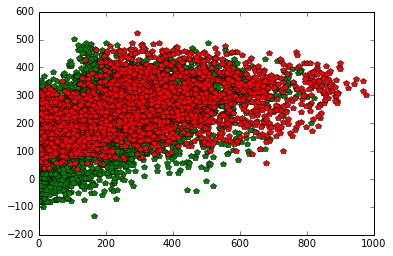

In [21]:
plt.plot(train_labels, pipe_best.predict(train_data), 'pg')
plt.plot(test_labels, pipe_best.predict(test_data), 'pr')

Модель не очень хорошая. Возвращает отрицательные значения (!). Имеется переобучение, т.е. train (зеленый) лучше, чем test (красный). Точки сильно не лежат на прямой.

### Случайный лес

In [22]:
ITrain, ITest = cv[0]
XTrain, XTest = X[ITrain], X[ITest]
yTrain, yTest = y[ITrain], y[ITest]

rf = ensemble.RandomForestRegressor()
rf.fit(XTrain, yTrain)

print metrics.mean_absolute_error(yTrain, rf.predict(XTrain))
print metrics.mean_absolute_error(yTest, rf.predict(XTest))

9.27278215223
51.809736681


In [62]:
zip(rf.feature_importances_, names)

[(0.0044435154988366893, 'season'),
 (0.00141288072588034, 'holiday'),
 (0.033843636397719513, 'workingday'),
 (0.013823543764939911, 'weather'),
 (0.085187116843907909, 'temp'),
 (0.061112535401659243, 'atemp'),
 (0.038700156834655219, 'humidity'),
 (0.010907630157444856, 'windspeed'),
 (0.6043434664893137, 'hour'),
 (0.011523699536409446, 'day'),
 (0.038220001684965005, 'month'),
 (0.053468972065117956, 'year'),
 (0.043012844599150162, 'dayofweek')]

hour, atemp. Согласуется с корелляцией

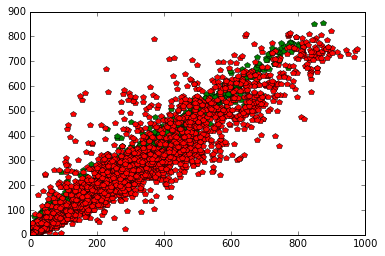

In [63]:
plt.plot(yTrain, rf.predict(XTrain), 'pg')
plt.plot(yTest, rf.predict(XTest), 'pr')

Гораздо лучше, уже нет отрицательных count. Точки почти на прямой.

### Опциональная часть

Попробуйте улучшить результат, полученный на предыдущих шагах. В этом разделе можно и нужно пользоваться любыми изученными алгоритмами, инструментами и всем, чем вам захочется.

In [37]:
rf1 = ensemble.RandomForestRegressor()

# множество параметров для поиска
parameters_grid1 = {
    'n_estimators' : [1, 10, 20, 30, 40, 50, 70, 100],
    'max_depth' : [None, 5, 10, 20, 30],
    'min_samples_leaf' : [1, 5, 10]
}


randomized_grid_cv1 = grid_search.GridSearchCV(rf1, parameters_grid1, scoring = 'mean_absolute_error', cv = cv)
# оптимизируем
randomized_grid_cv1.fit(X, y)

GridSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, ... 10872, 10873, 10874, 10875, 10876, 10877, 10878, 10879, 10880, 10881, 10882, 10883, 10884, 10885])],
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 10, 20, 30, 40, 50, 70, 100], 'max_depth': [None, 5, 10, 20, 30], 'min_samples_leaf': [1, 5, 10]},
       pre_dispatch='2*n_jobs', refi

In [38]:
print randomized_grid_cv1.best_score_
print randomized_grid_cv1.best_params_

-50.9023346601
{'n_estimators': 40, 'max_depth': None, 'min_samples_leaf': 1}


Результат немного улучшился

### Заключение

В этом разделе Вы можете написать, какие выводы Вы сделали в процессе работы над заданием, понравилось ли оно Вам, а также всё, что Вы о задании думаете =)

Интересное задание